In [1]:
# pytorch
import torch
import torchvision
from torchvision import models
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torch.distributions as td

# operations
import itertools
import pandas as pd
import time
import os

#plots
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)
from matplotlib.cbook import get_sample_data
from matplotlib import rcParams

#math
import numpy as np
from numpy.random import random
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm

#modules
from cifar10_models import resnet
import data_loader
import visualize
import train_model
import FGSM
import augment
import utility
import detect_adversarials
from temperature_scaling import ModelWithTemperature

sns.set_context("paper") 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Files already downloaded and verified
Files already downloaded and verified
Size of training set: 50000
Size of validation set: 7500
Size of test set: 2500


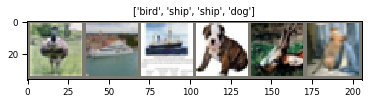

<All keys matched successfully>

In [2]:
#LOAD DATA
batch_size=100
trainloader, validloader, testloader, attributes=data_loader.load_cifar10(batch_size, valid_ratio=.75)
N_test=attributes["N_test"]
N_train=attributes["N_train"]
N_valid = attributes["N_valid"]
classes=attributes["class_names"]
print("Size of training set: {}".format(N_train))
print("Size of validation set: {}".format(N_valid))
print("Size of test set: {}".format(N_test))
# VISUALIZE
inputs, class_data = next(iter(trainloader))
visualize.imshow(inputs[:6], title=[classes[i] for i in class_data[:4]], savefigure="example1")

# load the pretrained resnet 18/34 or 50
path="cifar10_models/state_dicts/resnet50.pt"
model = resnet.resnet50(pretrained=True).to(device)
model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))

## Calibration

In [3]:
scaled_model = ModelWithTemperature(model)
structure=scaled_model.set_temperature(validloader)
temperature=structure.temperature
T=1.595

Before temperature - NLL: 0.349, ECE: 0.051
Optimal temperature: 1.500
After temperature - NLL: 0.293, ECE: 0.020


Epsilon: 0	Test Accuracy = 6895 / 7500 = 0.9193333333333333
Expected Calibration Error: 0.017443839460611343
Epsilon: 0	Test Accuracy = 6781 / 7500 = 0.9041333333333333
Expected Calibration Error: 0.016500113531947136
Epsilon: 0.4	Test Accuracy = 3564 / 7500 = 0.4752
Expected Calibration Error: 0.3519103527069092
Epsilon: 0.4	Test Accuracy = 3819 / 7500 = 0.5092
Expected Calibration Error: 0.32516592741012573


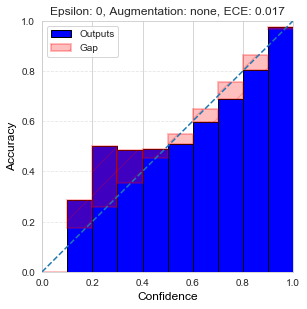

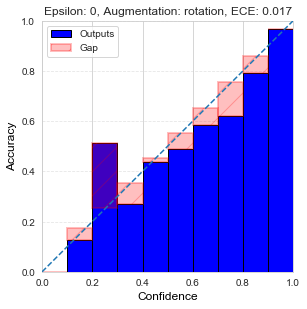

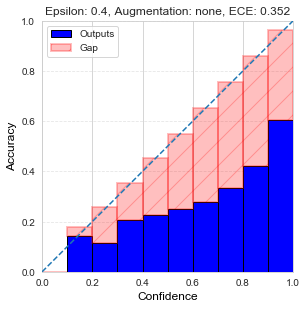

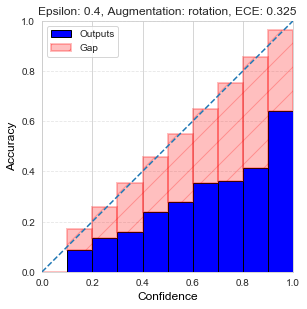

In [4]:
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 0, 
                                                                             epsilon=0,
                                                                             augmentations = "none", n = 1, temperature=T)
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
title = "Epsilon: {}, Augmentation: {}, ECE: {}".format(0, "none", round(float(ece),3))
fig1 = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title, plot_n=1)
print("Expected Calibration Error: {}".format(ece))

final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 0, 
                                                                             epsilon=0,
                                                                             augmentations = "r", n = 1, temperature=T)
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
title = "Epsilon: {}, Augmentation: {}, ECE: {}".format(0, "rotation", round(float(ece),3))
fig2 = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title, plot_n=1)
print("Expected Calibration Error: {}".format(ece))

final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 0, 
                                                                             epsilon=0.4,
                                                                             augmentations = "none", n = 1, temperature=T)
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
title = "Epsilon: {}, Augmentation: {}, ECE: {}".format(0.4, "none", round(float(ece),3))
fig3 = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title, plot_n=1)
print("Expected Calibration Error: {}".format(ece))

final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 0, 
                                                                             epsilon=0.4,
                                                                             augmentations = "r", n = 1, temperature=T)
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
title = "Epsilon: {}, Augmentation: {}, ECE: {}".format(0.4, "rotation", round(float(ece),3))
fig4 = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title, plot_n=1)
print("Expected Calibration Error: {}".format(ece))

In [31]:
from matplotlib.backends.backend_pdf import PdfPages

fig1.savefig( "figures/calibration_1.png",bbox_inches='tight',dpi=200)
fig2.savefig( "figures/calibration_2.png",bbox_inches='tight',dpi=200)
fig3.savefig( "figures/calibration_3.png",bbox_inches='tight',dpi=200)
fig4.savefig( "figures/calibration_4.png",bbox_inches='tight',dpi=200)

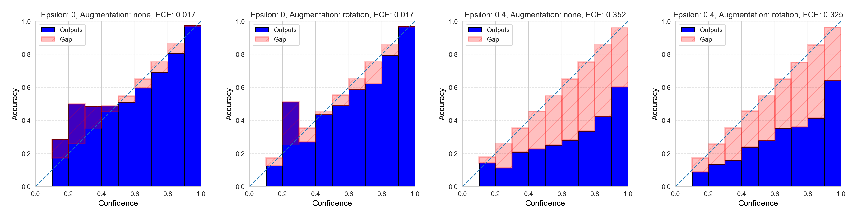

In [33]:
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 12 ,12
n_img=4
row=0
col=4
fig, ax = plt.subplots(1,col)
for i in range(n_img):
    # read images
    img = mpimg.imread("figures/"+"calibration_"+str(i+1)+".png")
    # display images
    ax[i].axis('off')
    ax[i].imshow(img);
    plt.tight_layout()
 
fig.savefig("figures/calibration_plots.png",bbox_inches='tight',dpi=200)

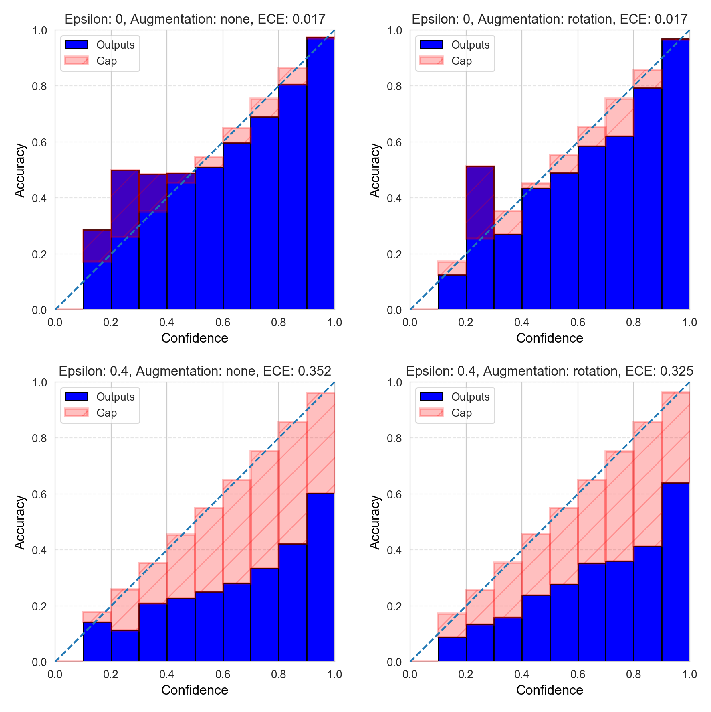

In [32]:
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 10 ,10
n_img=4
row=0
fig, ax = plt.subplots(2,2)
for i in range(n_img):
    # read images
    img = mpimg.imread("figures/"+"calibration_"+str(i+1)+".png")
    if i==2:
        row+=1
    if i>=2:
        i-=2
    # display images
    ax[row,i].axis('off')
    ax[row,i].imshow(img);
    plt.tight_layout()
fig.savefig("figures/calibration_grid.png",bbox_inches='tight',dpi=200)

## FID

In [27]:
#used to illustrate examples.
n_batches = 2
inputs_arr = []
iter_dataloader = iter(trainloader)
for _ in range(n_batches):
    cur_inputs, c =  next(iter_dataloader)
    inputs_arr.append(cur_inputs)
    
inputs = torch.cat(inputs_arr, dim = 0)
inputs.shape

# get model features
model_features, p = utility.get_features(model)

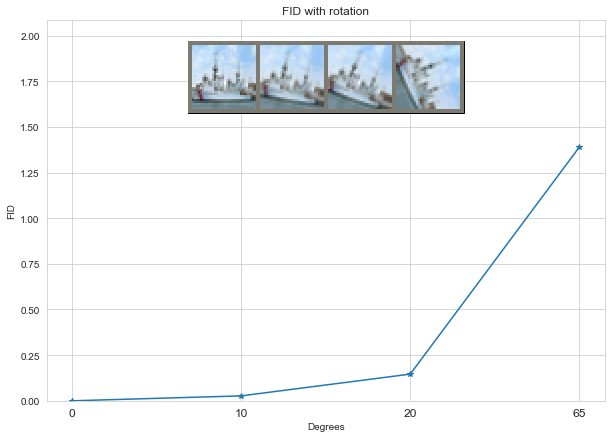

In [29]:
#params = [0,5,10,15]
#FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="g", noise_level=params, bottleneck=True)
#utility.plot_fid(FID, plot_batch, x_labels=params, title = "FID with Gaussian noise", plot_path="figures/fid_gaus.png")

params = [0,10,20,65]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="r", noise_level=params, bottleneck = True)
utility.plot_fid(FID, plot_batch, x_labels=params, title="FID with rotation", xlabel="Degrees",figsize=(10, 7),plot_path="figures/fid_rot.png")

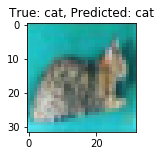

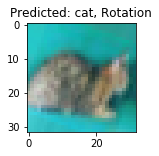

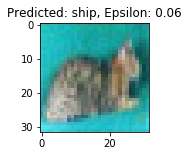

In [8]:
rcParams['figure.figsize'] = 3 ,3
rcParams['axes.grid'] = False
inputs, class_data = next(iter(validloader))

input_n = 10
choose_img = 7

aug_batches, aug_seqs, aug_seqs_names = augment.compute_augmentations(inputs[:input_n], n = 1, depth = 1, augmentations="none", rot=0)
aug_batches_rot, aug_seqs_rot, aug_seqs_names_rot = augment.compute_augmentations(inputs[:input_n], n = 1, depth = 1, augmentations="r", rot=20)
adv_examples, _=FGSM.get_examples_fgsm(model, validloader, epsilon=0.06, limit=input_n)
model.eval()
with torch.no_grad():
    outputs = model(aug_batches[0][choose_img].view(1,3,32,32).cuda())
    _, preds = torch.max(outputs, 1)
    pred_orig=classes[preds]
    outputs = model(aug_batches_rot[0][choose_img].view(1,3,32,32).cuda())
    _, preds = torch.max(outputs, 1)
    pred_rot=classes[preds]
    outputs = model(adv_examples[choose_img].view(1,3,32,32).cuda())
    _, preds = torch.max(outputs, 1)
    pred_adv=classes[preds]

visualize.imshow(aug_batches[0][choose_img], title="True: "+classes[class_data[choose_img]]+", Predict: "+str(pred_orig), savefigure="plot_1")
visualize.imshow(aug_batches_rot[0][choose_img], title="Predict: "+pred_rot+ ", Rotation", savefigure="plot_2")
visualize.imshow(adv_examples[choose_img], title="Predict: "+pred_adv+ ", Eps: 0.06", savefigure="plot_3")

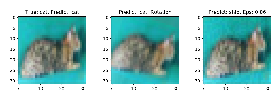

In [17]:
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 4 ,4
n_img=3
row=0
col=3
fig, ax = plt.subplots(1,col)
for i in range(n_img):
    # read images
    img = mpimg.imread("figures/"+"plot_"+str(i+1)+".png")
    # display images
    ax[i].axis('off')
    ax[i].imshow(img);
    plt.tight_layout()
fig.savefig("figures/plots_final.png",bbox_inches='tight',dpi=200)